# Solution Exercise 8: Self Supervised Learning

**Summer Semester 2025**

**Author**: Nick Stracke (nick.stracke@lmu.de)

## Instructions

Parts where code should be added are marked using `TODO`. You shouldn't have to edit anything else with the exception of imports.

*Please* add extensive comments to your code to explain what you're doing/trying to do. It is hard to assign partial points for incorrect or incomplete solutions if we do not understand what you are trying to do.

# Task 1: Temperature in Self Supervised Learning

In [2]:
import torch
import matplotlib.pyplot as plt

### Task 1.1: Visualizing the Effect of Temperature

In [3]:
def softmax_temp(logits: torch.Tensor, tau: float = 1.0) -> torch.Tensor:
    """
    Applies the softmax function with temperature.

    Parameters:
        logits (torch.Tensor, shape (N,)): A tensor containing the raw scores or logits.
        tau (float, optional): The temperature parameter to scale the logits. Default is 1.0.

    Returns:
        torch.Tensor: A tensor containing the probabilities after applying the softmax function.
    """
    scaled = logits / tau
    return torch.softmax(scaled, dim=0)

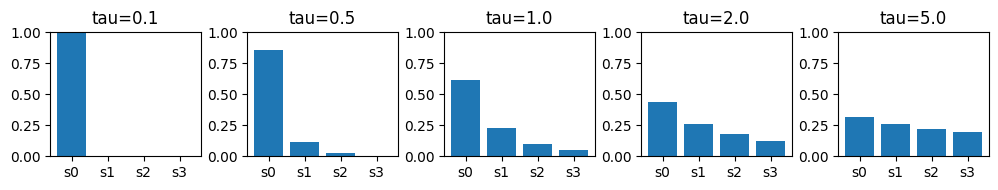

In [4]:
sims = torch.tensor([2.0, 1.0, 0.2, -0.5])
temps = [0.1, 0.5, 1.0, 2.0, 5.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

### Task 1.2 Intuition: Confidence vs. Uncertainty

##### What happens to the distribution when the temperature is very low (e.g., τ = 0.1)? What does this mean in terms of model confidence?

Low τ (e.g. 0.1) makes the softmax output very sharp, almost like a one-hot vector. The model becomes very confident, assigning nearly all probability mass to the highest-scoring input.

##### What happens when τ is very high (e.g., τ = 10.0)? What does this mean for the model’s ability to focus?

High τ (e.g. 10.0) flattens the softmax output, making the distribution nearly uniform. The model becomes uncertain and considers all candidates almost equally likely, reducing its ability to focus on the correct answer.

### Task 1.3 Why Temperature Matters in Contrastive Learning

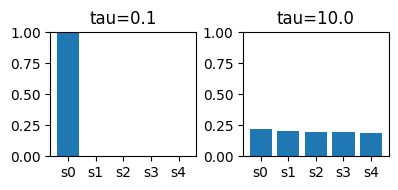

In [5]:
sims = torch.tensor([1.0, 0.2, 0.1, -0.1, -0.3])
temps = [0.1, 10.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

##### Discuss: Why might a sharper distribution (lower τ ) help the model learn more effectively?

A sharper distribution helps in contrastive learning because it strengthens the signal for the correct (positive) sample while suppressing noise from similar but incorrect (negative) samples. This leads to stronger gradients and faster, more effective learning.

# Task 2: SimCLR

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from ex8_2_solution import SimCLRModel
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
from tqdm import tqdm
import torch.nn as nn

### Task 2.1: Implement and Train a SimCLR Model
##### Switch to ex2.py to complete the implementation and train the SimCLR model. Come back here once you have a trained checkpoint.

### Task 2.2: Visualize with t-SNE

100%|██████████| 40/40 [00:02<00:00, 15.32it/s]


Running t-SNE...


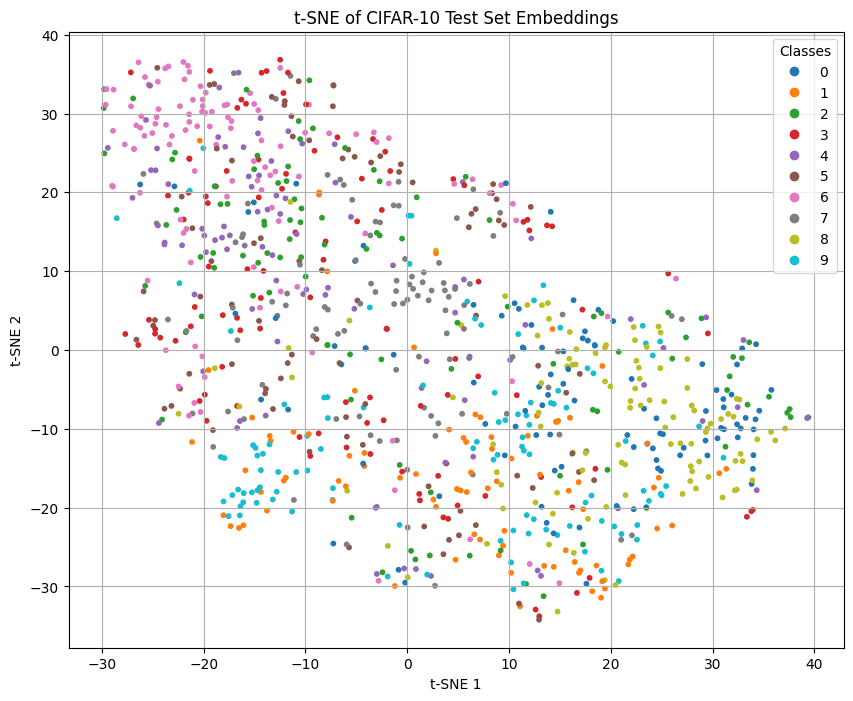

In [7]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
test_batch_size = 256
model = SimCLRModel()
model.load_state_dict(torch.load("simclr_model.pth", map_location="cpu"))
model.eval()
model.to(device)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=T.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, train_labels in tqdm(test_loader):
        imgs = imgs.to(device)
        train_features = model.encoder(imgs)
        all_embeddings.append(train_features.cpu())
        all_labels.append(train_labels)

all_embeddings = torch.cat(all_embeddings, dim=0).squeeze().numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

subset_embeddings = all_embeddings[:1000]  # Subset for faster t-SNE
subset_labels = all_labels[:1000]

print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
tsne_result = tsne.fit_transform(subset_embeddings)

# --- Plotting ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=subset_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of CIFAR-10 Test Set Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

### Task 2.3: Quantitative Evaluation using Linear Probing

In [8]:
# CONFIG
num_classes = 10  # CIFAR-10 has 10 classes
train_batch_size = 256
epochs = 50

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)

train_features, train_labels = [], []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x = x.to(device)
        h = model.encoder(x)
        train_features.append(h.cpu())
        train_labels.append(y)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

100%|██████████| 196/196 [00:11<00:00, 17.30it/s]


In [9]:
probe = nn.Linear(512, num_classes).to(device) # Probe to classification. 
probe_opt = torch.optim.Adam(probe.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

# Train probe
for epoch in range(epochs):
    perm = torch.randperm(train_features.size(0))
    train_features, train_labels = train_features[perm], train_labels[perm]
    total_loss = 0
    for i in range(0, len(train_features), train_batch_size):
        xb = train_features[i:i+train_batch_size].to(device)
        yb = train_labels[i:i+train_batch_size].to(device)
        logits = probe(xb)
        loss = ce(logits, yb)
        probe_opt.zero_grad()
        loss.backward()
        probe_opt.step()
        total_loss += loss.item()
    print(f"Probe epoch {epoch+1}, loss: {total_loss:.4f}")

: 

In [1]:
# Test probe
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        h = model.encoder(x)
        preds = probe(h).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"\nLinear probe test accuracy: {correct / total * 100:.2f}%")

NameError: name 'torch' is not defined

# Task 3: CLIP for Zero-Shot Classification

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import requests

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


###  Task 3.2: Implement a Zero-Shot Classifier with CLIP

In [4]:
# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# Example images (students can add more)
image_urls = [
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d",  # dog
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",  # cat
]

images = [Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in image_urls]

ImportError: 
CLIPModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [12]:
text_prompts = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a animal",
    "a photo of a horse",
    "a photo of a car",
]

In [13]:
# Prepare inputs for CLIP
inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # shape [num_images, num_texts]
    probs = logits_per_image.softmax(dim=1)

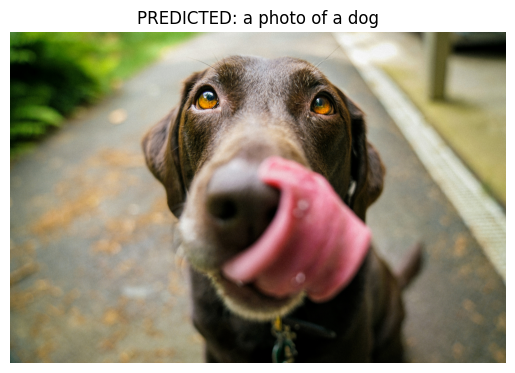

Probabilities:
  a photo of a dog         : 0.92
  a photo of a cat         : 0.00
  a photo of a animal      : 0.06
  a photo of a horse       : 0.02
  a photo of a car         : 0.00



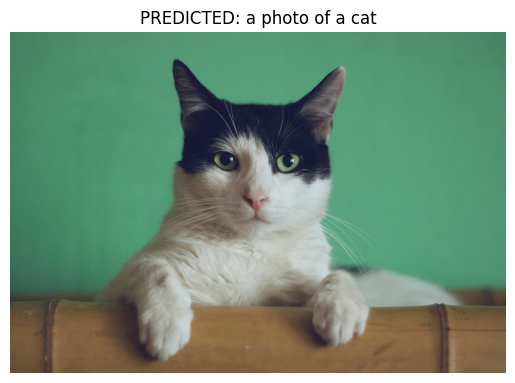

Probabilities:
  a photo of a dog         : 0.01
  a photo of a cat         : 0.95
  a photo of a animal      : 0.04
  a photo of a horse       : 0.00
  a photo of a car         : 0.00



In [14]:
# Print predictions
for i, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"PREDICTED: {text_prompts[probs[i].argmax()]}")
    plt.show()
    print("Probabilities:")
    for j, txt in enumerate(text_prompts):
        print(f"  {txt:<25}: {probs[i][j]:.2f}")
    print()

### Task 3.3: Discussion

##### Try varying your text prompts. Does the classification change?

Yes, changing the wording of the text prompt can significantly affect predictions. For example, “a photo of a dog” might work better than just “dog” or “animal.” This shows that CLIP is sensitive to the phrasing and context of the text.

##### What kind of errors does CLIP make? Are they semantically reasonable?

CLIP’s errors are often semantically close. For example, it might confuse “dog” and “wolf,” or “cat” and “tiger.” This suggests it understands the general concept but can struggle with fine-grained distinctions or ambiguous inputs.

##### How does this compare to traditional classification models?

Traditional classifiers require training on labeled examples and are limited to predefined classes. CLIP, by contrast, can generalize to unseen classes at inference time just by using natural language descriptions, which is a powerful form of zero-shot learning.